<a href="https://colab.research.google.com/github/BojanFaletic/research/blob/master/TimeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install einops

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
from einops import rearrange
import matplotlib.pyplot as plt

In [3]:
data = np.load('weak_data.npy')

In [4]:
s = rearrange(data, 'w d h -> (w d) h')

In [5]:
class TimeNet(nn.Module):
    def __init__(self, hr_inp=24):
        super().__init__()
        self.l = nn.LSTM(hr_inp, hr_inp, num_layers=2)
        self.fc1 = nn.Linear(hr_inp, hr_inp)
        self.fc2 = nn.Linear(hr_inp, 1)
    
    def forward(self, x):
        x, _ = self.l(x)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [6]:
s_flat = np.array([np.uint8(x>1) for x in s.flatten()])
HR_DATA = (7*24)*1

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = TimeNet(HR_DATA)
net = net.to(device)
X = np.array([s_flat[i:i+HR_DATA] for i in range(len(s_flat[:-HR_DATA]))])
Y = np.array( s_flat[HR_DATA:], dtype=np.uint8)

X = X.reshape(-1, HR_DATA)
Y = Y.reshape(-1, 1)

x_sz = int(X.shape[0] * 0.8 )

In [7]:
X_in = torch.Tensor(X[:x_sz])
Y_in = torch.Tensor(Y[:x_sz])

X_val = torch.Tensor(X[x_sz:])
Y_val = torch.Tensor(Y[x_sz:])


In [8]:
d_set_val = TensorDataset(X_val, Y_val)
d_set_train = TensorDataset(X_in, Y_in)

dataloader_val = DataLoader(d_set_val, batch_size=8,
                        shuffle=False, num_workers=0)

dataloader_train = DataLoader(d_set_train, batch_size=8,
                        shuffle=False, num_workers=0)

In [11]:
def test():
    net.eval()   
    err = 0
    for i,(x, y) in enumerate(dataloader_val):
        # prob out
        x = x.expand(1, -1, HR_DATA)
        x = x.to(device)
        p_output = net(x)
        yy = p_output.cpu().detach().numpy()
        xx = y.numpy()
        err += np.sum(np.abs(yy - xx) > 0.5)
    err = err / np.prod(Y_val.shape)
    print(f'Eval Acc: {(1-err)*100: .2f}%')

In [14]:
test()

Eval Acc:  77.19%


In [ ]:
# save model
torch.save(net, 'time_net.pth')
net = torch.load('time_net.pth')

In [20]:
loss = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5, amsgrad=1)
scheduler = StepLR(optimizer, 1, gamma=0.99)

def train():   
    for eps in range(20):
        net.train()
        err = 0
        for i,(x,y) in enumerate(dataloader_train):
            optimizer.zero_grad()

            # prob out
            x = x.expand(1, -1, HR_DATA).to(device)
            p_output = net(x)

            #p_output = p_output.squeeze(0)
            y = y.expand(1, -1, 1).to(device)
            
            #print(p_output.shape, y.shape)
            #print(p_output, y)

            error = loss(p_output, y)
            error.backward()
            optimizer.step()
            err += error.item()

        #print(f'Eps: {eps}, Train Loss: {err : .2f}')
        print(f"Epoch: {eps}, Optimizer lr: {scheduler.get_last_lr()[0]:.2e}")
        test()
        scheduler.step()
train()



Epoch: 0, Optimizer lr: 1.00e-03
Eval Acc:  79.98%
Epoch: 1, Optimizer lr: 9.90e-04
Eval Acc:  78.70%
Epoch: 2, Optimizer lr: 9.80e-04
Eval Acc:  78.63%
Epoch: 3, Optimizer lr: 9.70e-04
Eval Acc:  79.07%
Epoch: 4, Optimizer lr: 9.61e-04
Eval Acc:  79.20%
Epoch: 5, Optimizer lr: 9.51e-04
Eval Acc:  79.42%
Epoch: 6, Optimizer lr: 9.41e-04
Eval Acc:  79.32%
Epoch: 7, Optimizer lr: 9.32e-04
Eval Acc:  79.54%
Epoch: 8, Optimizer lr: 9.23e-04
Eval Acc:  79.04%
Epoch: 9, Optimizer lr: 9.14e-04
Eval Acc:  79.39%
Epoch: 10, Optimizer lr: 9.04e-04
Eval Acc:  78.88%
Epoch: 11, Optimizer lr: 8.95e-04
Eval Acc:  78.98%
Epoch: 12, Optimizer lr: 8.86e-04
Eval Acc:  79.61%
Epoch: 13, Optimizer lr: 8.78e-04
Eval Acc:  78.88%
Epoch: 14, Optimizer lr: 8.69e-04
Eval Acc:  79.14%
Epoch: 15, Optimizer lr: 8.60e-04
Eval Acc:  79.73%
Epoch: 16, Optimizer lr: 8.51e-04
Eval Acc:  79.01%
Epoch: 17, Optimizer lr: 8.43e-04
Eval Acc:  79.20%
Epoch: 18, Optimizer lr: 8.35e-04
Eval Acc:  79.73%
Epoch: 19, Optimizer l

In [21]:
X_sim = X_val.reshape(-1, HR_DATA)
Y_sim = Y_val.reshape(-1, 1)

In [22]:
out = np.array([np.round(net(x.expand(1,1,-1).to(device)).cpu().detach().numpy(), 2) for x in X_sim]).flatten()

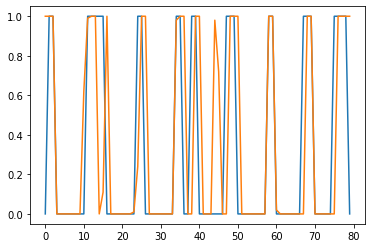

In [24]:
O = 200
L = 80
t = np.arange(L)
plt.plot(t, Y_sim[O:O+L], t, out[O:O+L])